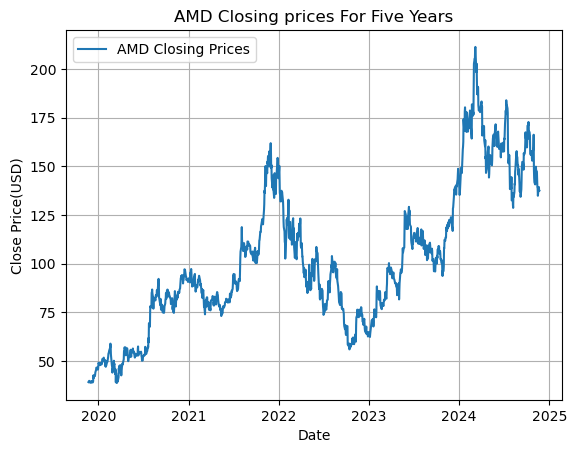

In [167]:
#Visual of Data


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf 


#Fetch Data 
ticker = yf.Ticker('AMD')
dfAMD = ticker.history(period='5y')

dates = dfAMD.index.to_numpy()
closing_prices = dfAMD['Close'].to_numpy()

plt.plot(dates, closing_prices, label='AMD Closing Prices')
plt.title('AMD Closing prices For Five Years')
plt.xlabel('Date')
plt.ylabel('Close Price(USD)')
plt.grid(True)
plt.legend()
plt.show()



In [168]:
# Check for Stationary Uisng ADF Test 
from statsmodels.tsa.stattools import adfuller

result = adfuller(dfAMD['Close'])

adf_statistic= result[0]
p_value = result[1]
critical_values = result[4]

print (f'ADF Statistic: {adf_statistic}')
print (f'p-value: {p_value}')
print ('\nCritical Values:')
for key, value in critical_values.items():
    print(f' {key}:{value}')


if result[1]<0.05:
    print("Data is Stationary")
else:
    print("Not Stationary")


    
#p-Value is greater than 0.05 we have to diiference it





ADF Statistic: -1.9552167031470318
p-value: 0.3065473920978382

Critical Values:
 1%:-3.4355629707955395
 5%:-2.863842063387667
 10%:-2.567995644141416
Not Stationary


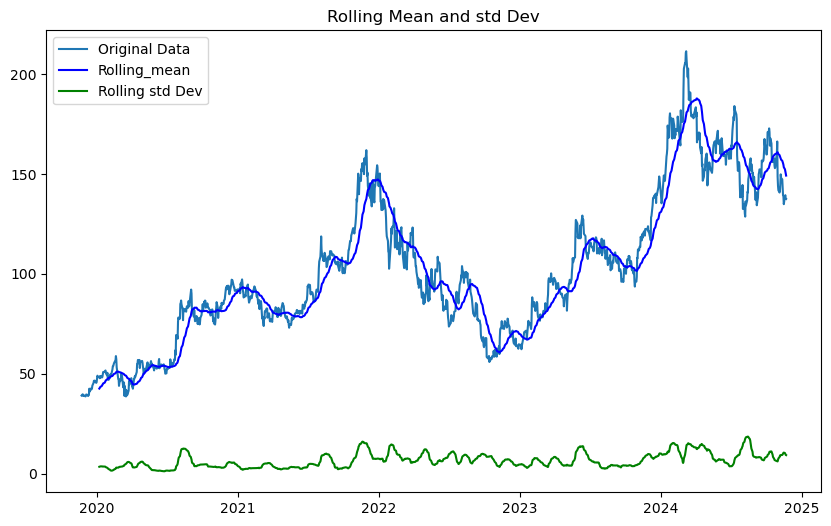

In [169]:
#visual inspection to check stationary 
#using Rolling mean & rolling standard deviation (data will not be constant with high & lows) 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import yfinance as yf
ticker= yf.Ticker('AMD')
dfAMD= ticker.history(period='5y')
rolling_mean = dfAMD['Close'].rolling(window=30).mean()
rolling_std = dfAMD['Close'].rolling(window =30).std()

plt.figure(figsize=(10,6))
plt.plot(dfAMD['Close'], label='Original Data')
plt.plot(rolling_mean, label='Rolling_mean', color='blue')
plt.plot(rolling_std, label='Rolling std Dev', color='green')
plt.legend()
plt.title("Rolling Mean and std Dev")
plt.show()


           

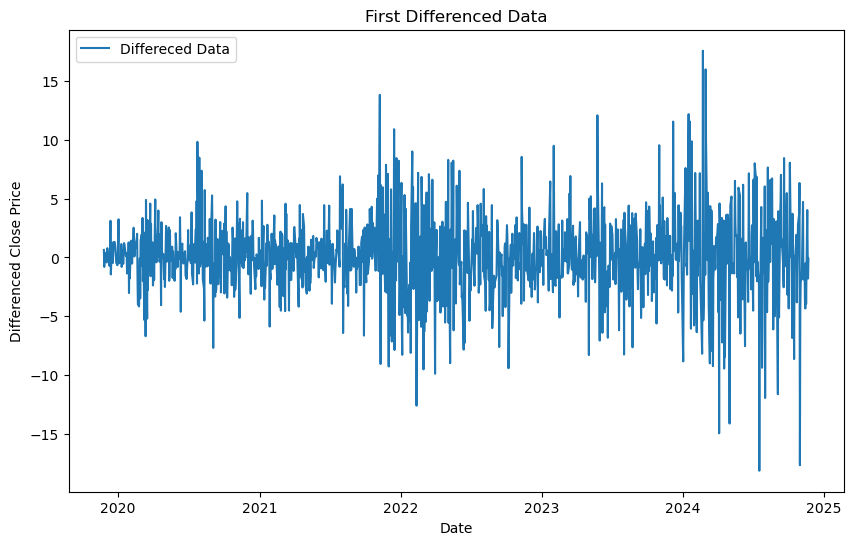

ADF Statistic: -36.57774523761858
p-value: 0.0
Critical Values:
1%: -3.4355671297788666
5%: -2.8638438984080117
10%: -2.5679966213893057
Data is Stationary
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6682.219, Time=1.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6679.309, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6679.992, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6679.976, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6677.958, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6681.957, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.779 seconds
Auto ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1258
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3337.979
Date:                Thu, 21 Nov 2024   AIC                      

In [170]:
#visual inspection to check stationary 
#using Rolling mean & rolling standard deviation (data will not be constant with high & lows) 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

ticker= yf.Ticker('AMD')
dfAMD= ticker.history(period='5y')

#first Differencing
dfAMD['diff'] = dfAMD['Close'].diff()

plt.figure(figsize=(10,6))
plt.plot(dfAMD['diff'], label='Differeced Data')
plt.title('First Differenced Data')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.legend()
plt.show()

#ADF Test
adf_result_diff = adfuller(dfAMD['diff'].dropna())

print(f'ADF Statistic: {adf_result_diff[0]}')
print(f'p-value: {adf_result_diff[1]}')
print("Critical Values:")
for key, value in adf_result_diff[4].items():
    print(f"{key}: {value}")

if adf_result_diff[1] <0.05:
    print("Data is Stationary")
else:
    print("Data is not Stationary")

# use finction auto to identify parametrs of ARIMA ( p,d,q)

auto_model = pm.auto_arima(dfAMD['Close'],
                           seasonal= False,
                           trace=True,
                           stepwise=True)

print("Auto ARIMA Model Summary:")
print(auto_model.summary())



           

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


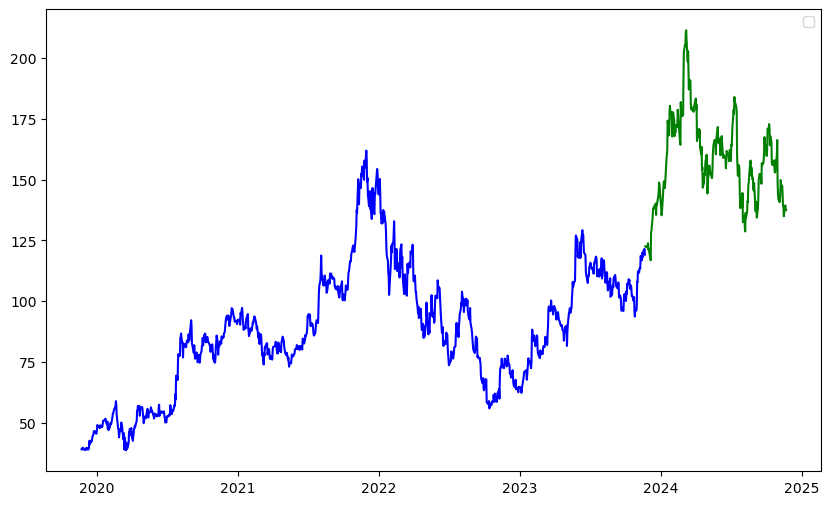

In [171]:
#split data 
train_size = int(len(closing_prices)*0.8)
train= closing_prices[:train_size]
test=closing_prices[train_size:]

train_dates= dates[:train_size]
test_dates= dates[train_size:]

plt.figure(figsize=(10,6))
plt.plot(train_dates, train, color='blue')
plt.plot(test_dates, test, color='green')
plt.legend()
plt.show()



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1006
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2523.836
Date:                Thu, 21 Nov 2024   AIC                           5053.672
Time:                        23:27:48   BIC                           5068.411
Sample:                             0   HQIC                          5059.273
                               - 1006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1978      0.482      0.410      0.682      -0.747       1.143
ma.L1         -0.2412      0.478     -0.504      0.614      -1.179       0.696
sigma2         8.8875      0.285     31.228      0.0

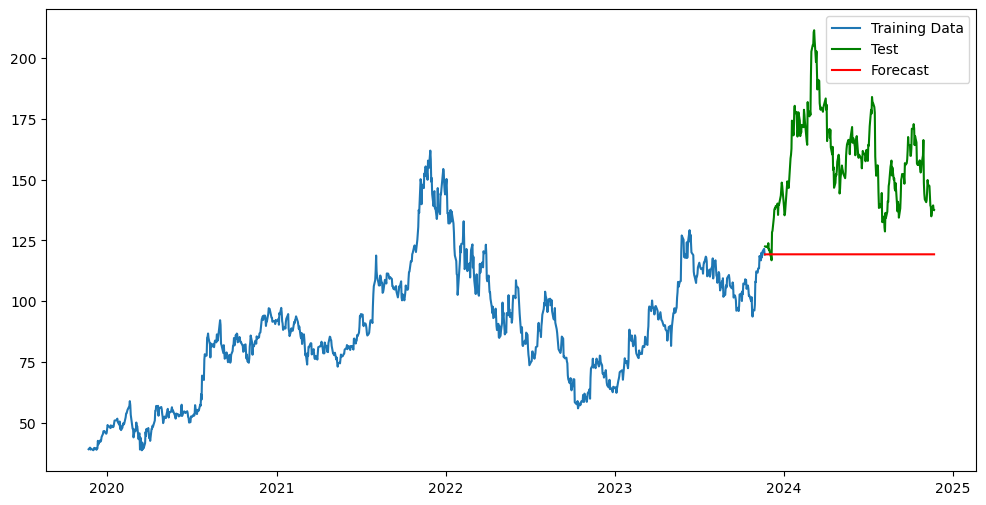

In [172]:
#Train model using ARIMA
from statsmodels.tsa.arima.model import ARIMA
best_order= (2,1,1)
model = ARIMA(train, order=best_order)
model_fit= model.fit()
print(model_fit.summary())

# forecast Test Data 
predications = model_fit.forecast(steps=len(test))



plt.figure(figsize=(12,6))
plt.plot(train_dates, train, label='Training Data')
plt.plot(test_dates, test, label='Test', color='green')
plt.plot(test_dates, predications, label='Forecast', color='red')
plt.legend()
plt.show()

           
